# Import 

In [1]:
import cv2 as cv
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from enum import Enum
from itertools import groupby
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from config import MODEL_PARAMS, ENCODING_DICT, DECODING_DICT
from misc import HorizontalMirrorImage, ScaleVertically, ScaleHorizontally
from model import WordReader
from utils import encode_character, decode_text

# Config

## Data Path

In [2]:
PREPROCESSED_IMAGE_PATH = 'augmented-data/images'
METADATA_PATH = 'augmented-data/metadata.csv'

os.makedirs('models', exist_ok=True)
MODEL_PATH = 'models/best_model_accuracy={:.0f}.pth'

## Parameters

In [3]:
TRAINING_PARAMS = {
    'epochs': 20,
    'test_size': 0.2,
    'learning_rate': 0.001,
    'random_state': 42,
    'batch_size': 128,
    'lr_schedular_patiance': 5
}

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

DATASET_SIZE = 1_000_000
RANDOM_SEED = 42

# Utils

## Image

In [4]:
def read_image_gray_scale(image_path):
    return cv.imread(image_path, flags=cv.IMREAD_GRAYSCALE)

## Debug

In [5]:
DEBUG = True

def summarize_pdf(df, number_of_rows=3):
    if DEBUG:
        print('len of df: {}'.format(len(df)))
        display(df.head(number_of_rows))

class LogLevel(Enum):
    info = logging.INFO
    error = logging.ERROR

def set_log_level(logger, log_level):
    logger.setLevel(log_level.value)

logger = logging.getLogger()
set_log_level(logger, LogLevel.error)

# Main

## Load Dataset

In [6]:
def create_dataset(
    processed_image_dir,
    metadata_pdf,
    alphabet_to_num_dictionary
):
    dataset = []
    for index, row in metadata_pdf.iterrows():
        try:
            image = read_image_gray_scale(os.path.join(processed_image_dir, '{}.png'.format(row['id'])))
            embeded_label = encode_character(row['label'], alphabet_to_num_dictionary)
            dataset.append((image, embeded_label))
        except Exception as e:
            print('Error in index {}: {}'.format(index, row['label']))
    return dataset

metadata_pdf = pd.read_csv(METADATA_PATH)#.sample(n=DATASET_SIZE, random_state=RANDOM_SEED)
dataset = create_dataset(
    PREPROCESSED_IMAGE_PATH,
    metadata_pdf,
    ENCODING_DICT
)
train_dataset, validation_dataset = train_test_split(
    dataset,
    test_size=TRAINING_PARAMS['test_size'],
    random_state=TRAINING_PARAMS['random_state'],
    shuffle=True
)
print('Meta Data Size: {}'.format(len(metadata_pdf)))
print('Train Size: {}'.format(len(train_dataset)))
print('Validation Size: {}'.format(len(validation_dataset)))

Error in index 212727: آیۀ
Error in index 212778: وظیفۀ
Error in index 212836: مطالبۀ
Error in index 212928: وظیفۀ
Error in index 213013: جایزۀ
Error in index 213176: خلاصۀ
Error in index 245836: بازماندۀ
Error in index 257982: پدیدۀ
Error in index 257986: استفادۀ
Error in index 258022: ارائۀ
Error in index 258150: حادثۀ
Error in index 509472: جشنوارۀ
Error in index 509485: دورۀ
Error in index 509486: جشنوارۀ
Error in index 509542: مرحلۀ
Error in index 509569: جشنوارۀ
Error in index 509604: نتیجۀ
Error in index 540580: فاصلۀ
Error in index 540665: جامعۀ
Error in index 540726: فاصلۀ
Error in index 540767: عمدۀ
Error in index 540808: تجربۀ
Error in index 540822: استفادۀ
Error in index 540878: دربارۀ
Error in index 540893: برنامۀ
Error in index 540964: داد:برنامۀ
Error in index 540996: مجموعۀ
Error in index 642535: مرحلۀ
Error in index 642580: هزینۀچاپ
Error in index 642739: مجموعۀ
Error in index 779468: ارایۀ
Error in index 779475: دورۀ
Error in index 779485: بودجۀ
Error in index 779504:

## Dataset

In [7]:
class WordDataset(Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = image.astype('float32') / 255
        if self.transforms is not None:
            image = self.transforms(image)


        image = torch.tensor(image[np.newaxis, ...])
        label = torch.Tensor(label)
        return image, label

## Dataloader

In [8]:
def collate(batch: list):
    images, labels = map(list, zip(*batch))
    padded_images = []
    for image in images:
        padded_images.append(image[0].unsqueeze(dim=0))

    images = torch.cat(padded_images).unsqueeze(dim=1)
    labels = nn.utils.rnn.pad_sequence(
        sequences=labels,
        batch_first=True,
        padding_value=0
    )

    return images, labels

train_dataloader = DataLoader(
    WordDataset(train_dataset, transforms=transforms.Compose([
        HorizontalMirrorImage(), 
        ScaleVertically(desired_height=MODEL_PARAMS['desired_image_height']),
        ScaleHorizontally(desired_width=MODEL_PARAMS['desired_image_width'])
    ])),
    batch_size=TRAINING_PARAMS['batch_size'],
    shuffle=True,
    collate_fn=collate
)
validation_dataloader = DataLoader(
    WordDataset(validation_dataset, transforms=transforms.Compose([
        HorizontalMirrorImage(), 
        ScaleVertically(desired_height=MODEL_PARAMS['desired_image_height']),
        ScaleHorizontally(desired_width=MODEL_PARAMS['desired_image_width'])
    ])),
    batch_size=TRAINING_PARAMS['batch_size'],
    shuffle=True,
    collate_fn=collate
)

## Model

In [9]:
model = WordReader().to(DEVICE)
criterion = nn.CTCLoss(blank=MODEL_PARAMS['blank_label'], reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=TRAINING_PARAMS['learning_rate'])
learning_rate_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', verbose=True,
    patience=TRAINING_PARAMS['lr_schedular_patiance']
)

/home/amir/personal/.venv/base/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training

In [10]:
def count_corrects_on_batch(
    x, y_pred, y_true, blank=MODEL_PARAMS['blank_label'], 
    device=DEVICE, decoding_dict=DECODING_DICT
):
    def check_if_lists_are_same(prediction, y_true):
        return prediction == y_true

    correct = 0
    num = 0
    _ ,max_index = torch.max(y_pred, dim=2)

    for i in range(x.shape[0]):
        raw_prediction = list(max_index[:, i].detach().cpu().numpy())
        prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank]).to(device)

        decoded_prediction = decode_text(prediction, decoding_dict).replace(' ', '')
        decoded_label = decode_text(y_true[i].detach().cpu().numpy(), decoding_dict).replace(' ', '')

        logging.info(f"Decoded Prediction: {''.join(decoded_prediction)}")
        logging.info(f"Label:              {''.join(decoded_label)}")

        if check_if_lists_are_same(decoded_prediction, decoded_label):
            correct += 1
        num += 1

    return correct, num
    

def iterate_over_full_dataset(model, data_loader, device, criterion, is_training, optimizer):
    total_loss = 0
    batch_count = 0
    total_correct = 0
    total_num = 0

    for x, y in data_loader:
        batch_size = x.shape[0]
        x = x.to(device)
        y = y.to(device)

        if is_training:
            optimizer.zero_grad()

        y_pred = model(x)
        y_pred = y_pred.permute(1, 0 ,2)

        input_lengths = torch.IntTensor(batch_size).fill_(y_pred.shape[0])
        target_lengths = torch.IntTensor([len(t) for t in y])

        if is_training:
            loss = criterion(y_pred, y, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                loss = criterion(y_pred, y, input_lengths, target_lengths)

        total_loss += loss.item()
        batch_count += 1

        correct, num = count_corrects_on_batch(x, y_pred, y)
        total_correct += correct
        total_num += num

    return {'accuracy': round(total_correct/total_num, 3), 'loss': round(total_loss/batch_count, 3)}

In [11]:
train_losses = []
validation_losses = []

train_accs = []
validation_accs = []

best_val_acc = 0

for i in range(TRAINING_PARAMS['epochs']):
    print('Epoch: {}'.format(i+1))
    train_info = iterate_over_full_dataset(
        model,
        data_loader=train_dataloader,
        device=DEVICE,
        criterion=criterion,
        is_training=True,
        optimizer=optimizer
    )
    validation_info = iterate_over_full_dataset(
        model,
        data_loader=validation_dataloader,
        device=DEVICE,
        criterion=criterion,
        is_training=False,
        optimizer=optimizer
    )

    learning_rate_scheduler.step(validation_info['loss'])

    train_losses.append(train_info['loss'])
    train_accs.append(train_info['accuracy'])

    validation_losses.append(validation_info['loss'])
    validation_accs.append(validation_info['accuracy'])

    print('Train Info: {}'.format(train_info))
    print('Val Info: {}'.format(validation_info))

    if best_val_acc < validation_info['accuracy']:
        best_val_acc = validation_info['accuracy']
        torch.save(model.state_dict(), MODEL_PATH.format(100*best_val_acc))
        torch.save(model.state_dict(), 'models/best_model.pth')

Epoch: 1
Train Info: {'accuracy': 0.645, 'loss': 0.668}
Val Info: {'accuracy': 0.915, 'loss': 0.396}
Epoch: 2
Train Info: {'accuracy': 0.947, 'loss': 0.2}
Val Info: {'accuracy': 0.959, 'loss': 0.202}
Epoch: 3
Train Info: {'accuracy': 0.967, 'loss': 0.189}
Val Info: {'accuracy': 0.967, 'loss': 0.186}
Epoch: 4
Train Info: {'accuracy': 0.976, 'loss': 0.183}
Val Info: {'accuracy': 0.978, 'loss': 0.179}
Epoch: 5
Train Info: {'accuracy': 0.981, 'loss': 0.181}
Val Info: {'accuracy': 0.982, 'loss': 0.18}
Epoch: 6
Train Info: {'accuracy': 0.984, 'loss': 0.179}
Val Info: {'accuracy': 0.982, 'loss': 0.176}
Epoch: 7
Train Info: {'accuracy': 0.986, 'loss': 0.178}
Val Info: {'accuracy': 0.985, 'loss': 0.176}
Epoch: 8
Train Info: {'accuracy': 0.987, 'loss': 0.175}
Val Info: {'accuracy': 0.985, 'loss': 0.174}
Epoch: 9
Train Info: {'accuracy': 0.988, 'loss': 0.175}
Val Info: {'accuracy': 0.981, 'loss': 0.176}
Epoch: 10
Train Info: {'accuracy': 0.989, 'loss': 0.175}
Val Info: {'accuracy': 0.984, 'loss':

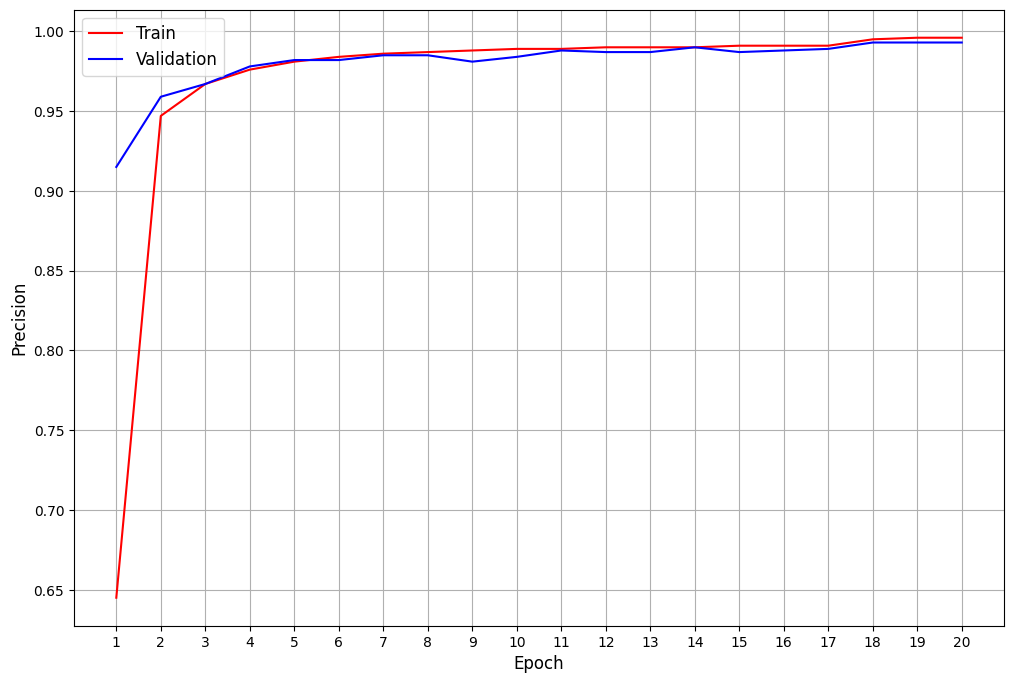

In [15]:
plt.figure(figsize=(12, 8))
plt.plot([x + 1 for x in range(20)], train_accs, color='r', label='Train')
plt.plot([x + 1 for x in range(20)], validation_accs, color='b', label='Validation')
plt.xticks([x + 1 for x in range(20)])
plt.legend(fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.grid()
plt.show()